In [7]:
import pandas as pd
import numpy as np
df = pd.read_json('pycharm_issues.json', lines=True)

In [8]:
# чуть-чуть глянем на содержимое
# какие версии есть в наличии, надо удалить все, что раньше 2020.2
versions = set()
for v in list(df['Affected versions']):
    for vv in v:
        versions.add(vv)
versions

{'2016.1',
 '2016.2',
 '2016.3',
 '2017.1',
 '2017.2',
 '2017.3',
 '2018.1',
 '2018.2',
 '2018.3',
 '2019.1',
 '2019.2',
 '2019.3',
 '2020.1',
 '2020.2',
 '2020.3',
 '2021.1',
 '2021.2',
 '2021.3'}

In [9]:
# select only versions after 2020.2
df = df[df["Affected versions"].apply(lambda v: any(x >= "2020.2" for x in v))]

In [10]:
# Заново переформируем индексы
df = df.reset_index()

In [11]:
df

,index,idReadable,created,summary,description,Affected versions
0,45,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3]
1,67,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2]
2,178,PY-22369,1485334537463,DataFrame auto-update doesn't work with action...,Consider this example:\n\n```python\nimport pa...,[2021.1]
3,266,PY-22469,1485863013851,PowerShell prompt doesn't show virtualenv,"Although the virtualenv seems activated, the p...",[2021.1]
4,730,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3]
...,...,...,...,...,...,...
2291,21992,PY-51608,1636987696450,Breakpoints not always hit in multi-threaded app,# Steps to Reproduce\n\nCreate a project using...,[2021.2]
2292,21994,PY-51621,1637063283050,code insighte: Quick solution (+error) instead...,"Hi,\n**What I do:**\nI open huge JSON file (ab...",[2021.2]
2293,22000,PY-51614,1637012454711,"IDE keeps disabling Python plugin, I get and e...",Here is the job log.\n\nI am unable to use the...,[2021.2]
2294,22008,PY-51605,1636977168955,"Better ""Invalid Python SDK"" handling",Quite often OS (usually macOS) or Python updat...,[2021.2]


Построим простую LDA, надо троить на данных, которые были в релизе 2020.2
для обучения склеим названия тикетов и их описание вместе.

Так как есть чать тикетов без описания, заменим его на пустые строки для корректного обучения

In [12]:
df['description'] = df['description'].replace(np.nan, "")

In [13]:
df['text'] = df['summary'] + ' ' + df['description']

In [14]:
df["head"] = df["summary"] + df["description"].apply(lambda x: x[:100])

In [15]:
df

,index,idReadable,created,summary,description,Affected versions,text,head
0,45,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3],Running subprocesses with Popen inside unittes...,Running subprocesses with Popen inside unittes...
1,67,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2],Full project optimize imports alters library f...,Full project optimize imports alters library f...
2,178,PY-22369,1485334537463,DataFrame auto-update doesn't work with action...,Consider this example:\n\n```python\nimport pa...,[2021.1],DataFrame auto-update doesn't work with action...,DataFrame auto-update doesn't work with action...
3,266,PY-22469,1485863013851,PowerShell prompt doesn't show virtualenv,"Although the virtualenv seems activated, the p...",[2021.1],PowerShell prompt doesn't show virtualenv Alth...,PowerShell prompt doesn't show virtualenvAltho...
4,730,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3],Project requirements are not detected from set...,Project requirements are not detected from set...
...,...,...,...,...,...,...,...,...
2291,21992,PY-51608,1636987696450,Breakpoints not always hit in multi-threaded app,# Steps to Reproduce\n\nCreate a project using...,[2021.2],Breakpoints not always hit in multi-threaded a...,Breakpoints not always hit in multi-threaded a...
2292,21994,PY-51621,1637063283050,code insighte: Quick solution (+error) instead...,"Hi,\n**What I do:**\nI open huge JSON file (ab...",[2021.2],code insighte: Quick solution (+error) instead...,code insighte: Quick solution (+error) instead...
2293,22000,PY-51614,1637012454711,"IDE keeps disabling Python plugin, I get and e...",Here is the job log.\n\nI am unable to use the...,[2021.2],"IDE keeps disabling Python plugin, I get and e...","IDE keeps disabling Python plugin, I get and e..."
2294,22008,PY-51605,1636977168955,"Better ""Invalid Python SDK"" handling",Quite often OS (usually macOS) or Python updat...,[2021.2],"Better ""Invalid Python SDK"" handling Quite oft...","Better ""Invalid Python SDK"" handlingQuite ofte..."


In [16]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [17]:
f_tickets_2 = df[df["Affected versions"].apply(lambda v: "2020.2" in v)]
f_tickets_3 = df[df["Affected versions"].apply(lambda v: "2020.3" in v)]

In [18]:
counter = CountVectorizer(stop_words='english', ngram_range=(2, 3), max_df=0.3)
X_2020_2 = counter.fit_transform(f_tickets_2["text"].values.astype('U'))

In [19]:
X_2020_2

<625x79549 sparse matrix of type '<class 'numpy.int64'>'
	with 106102 stored elements in Compressed Sparse Row format>

In [20]:
f_tickets_2.index

Int64Index([   1,    6,    9,   10,   16,   22,   29,   31,   32,   34,
            ...
             995,  998,  999, 1011, 1014, 1022, 1032, 1056, 1057, 1169],
           dtype='int64', length=625)

In [21]:
lda = LDA(n_components=8, random_state=7)
lda.fit(X_2020_2)

LatentDirichletAllocation(n_components=8, random_state=7)

In [22]:
counter.get_feature_names_out()

array(['00 00', '00 00 00000000', '00 00000000', ..., '进程已结束 退出代码0',
       '𝕡𝕣ⁱ𝕟𝕥 hello', '𝕡𝕣ⁱ𝕟𝕥 hello expected'], dtype=object)

In [23]:
lda.components_

array([[0.125     , 0.125     , 0.125     , ..., 0.125     , 0.12500363,
        0.12500363],
       [0.125     , 0.125     , 0.125     , ..., 0.125     , 1.12496853,
        1.12496853],
       [0.125     , 0.125     , 0.125     , ..., 1.125     , 0.125     ,
        0.125     ],
       ...,
       [0.125     , 0.125     , 0.125     , ..., 0.125     , 0.125     ,
        0.125     ],
       [0.125     , 0.125     , 0.125     , ..., 0.125     , 0.12502784,
        0.12502784],
       [0.125     , 0.125     , 0.125     , ..., 0.125     , 0.125     ,
        0.125     ]])

In [24]:
feature_names = counter.get_feature_names_out()[np.argsort(lda.components_, axis=-1)[:, ::-1]]
feature_names

array([['com intellij', 'intellij openapi', 'com intellij openapi', ...,
        '13 16 28', '13 16', '08 13 16'],
       ['11 10', '11 10 b944', '10 b944', ..., '12 04', '2020 12 04',
        '04 16 10'],
       ['java base', 'java base java', 'base java', ..., '04 16 10',
        '2020 12 04', '16 10'],
       ...,
       ['reproduce problem', 'steps reproduce problem',
        'happens instead', ..., '2020 12 04', '16 10', '12 04 16'],
       ['py line', 'file users', 'jre 11', ..., '12 04', '16 10',
        '04 16 10'],
       ['202 7660 27', '7660 27', '202 7660', ..., '12 04 16', '12 04',
        '04 16 10']], dtype=object)

In [25]:
tickets = lda.transform(X_2020_2)

In [26]:
f_tickets_2.iloc[tickets.argmax(axis=0)]

,index,idReadable,created,summary,description,Affected versions,text,head
760,18049,PY-45820,1607098503682,Last update not working on Ubuntu 20.4,OpenJDK 64-Bit Server VM warning: Option UseCo...,[2020.2],Last update not working on Ubuntu 20.4 OpenJDK...,Last update not working on Ubuntu 20.4OpenJDK ...
32,5708,PY-28703,1519758352285,Optimize import corrupts code with long import...,Optimizing imports on the following code:\n{co...,[2020.2],Optimize import corrupts code with long import...,Optimize import corrupts code with long import...
319,16748,PY-44032,1597357988369,Quick Evaluate Expression times out,When I try to use Quick Evaluate locally or in...,[2020.2],Quick Evaluate Expression times out When I try...,Quick Evaluate Expression times outWhen I try ...
383,16877,PY-44218,1598510515143,Jupyter Interpreter not Working,"Hello,\n\nI'm trying to run Jupyter Notebooks ...",[2020.2],"Jupyter Interpreter not Working Hello,\n\nI'm ...","Jupyter Interpreter not WorkingHello,\n\nI'm t..."
423,17001,PY-44404,1599576793284,PyCharm freezes multiple times a day with Stac...,On Ubuntu with Python 3.8.2 PyCharm freezes fr...,[2020.2],PyCharm freezes multiple times a day with Stac...,PyCharm freezes multiple times a day with Stac...
275,16659,PY-43865,1596653700322,Debugger crashes program with asyncio code,I try to debug this program and problems is st...,[2020.2],Debugger crashes program with asyncio code I t...,Debugger crashes program with asyncio codeI tr...
215,16478,PY-43599,1595499822750,Packages are not removed correctly if python c...,##### Case 1:\n**STR:**\n1. Install matplotlib...,[2020.2],Packages are not removed correctly if python c...,Packages are not removed correctly if python c...
233,16543,PY-43703,1596025961076,IndexError: Too many indices for array - GPU a...,**What steps will reproduce the problem?**\n1....,"[2020.1, 2020.2]",IndexError: Too many indices for array - GPU a...,IndexError: Too many indices for array - GPU a...


In [27]:
for value, code, name, v in zip(tickets.max(axis=0),  f_tickets_2.iloc[tickets.argmax(axis=0)]["idReadable"], f_tickets_2.iloc[tickets.argmax(axis=0)]['summary'], f_tickets_2.iloc[tickets.argmax(axis=0)]['Affected versions']):
    print(value, code, v, name)

0.9999726929196795 PY-45820 ['2020.2'] Last update not working on Ubuntu 20.4
0.998114143603153 PY-28703 ['2020.2'] Optimize import corrupts code with long import lines
0.9997752264096063 PY-44032 ['2020.2'] Quick Evaluate Expression times out
0.9986019080375321 PY-44218 ['2020.2'] Jupyter Interpreter not Working
0.999462974933042 PY-44404 ['2020.2'] PyCharm freezes multiple times a day with StackOverflowError
0.9992375898750934 PY-43865 ['2020.2'] Debugger crashes program with asyncio code
0.9993420534061161 PY-43599 ['2020.2'] Packages are not removed correctly if python console is opened
0.9988139078352771 PY-43703 ['2020.1', '2020.2'] IndexError: Too many indices for array - GPU array to CPU - Python Console


Если посмотреть на эти тикеты в ютреке, увидим, что они не очень содержалельные. Также видно, что часто в описание пихают что-то типа стектрейсов на много экранов, что мешает нормальному обучению модели. Поэтому обучимся на имени тикетов + части описаний

In [28]:
counter = CountVectorizer(stop_words='english', ngram_range=(2, 3), max_df=0.3)
X_2020_2 = counter.fit_transform(f_tickets_2["summary"].values.astype('U'))

In [29]:
lda = LDA(n_components=8, random_state=7)
lda.fit(X_2020_2)

LatentDirichletAllocation(n_components=8, random_state=7)

In [30]:
counter.get_feature_names_out()

array(['04 flatpak', '04 flatpak detect', '10 14', ..., 'zsh shell',
       'zshrc available', 'zshrc available jupyter'], dtype=object)

In [31]:
tickets = lda.transform(X_2020_2)

In [32]:
for value, code, name, v in zip(tickets.max(axis=0),  f_tickets_2.iloc[tickets.argmax(axis=0)]["idReadable"], f_tickets_2.iloc[tickets.argmax(axis=0)]['summary'], f_tickets_2.iloc[tickets.argmax(axis=0)]['Affected versions']):
    print(value, code, v, name)

0.966344484880639 PY-43176 ['2020.2'] Bug: Cannot open ReST files (2020.2 EAP version, ReStructured Text plugin bundled 202.5792.43)
0.9687470979697408 PY-44751 ['2020.2'] Pycharm Pro (installed on ubuntu 18.04 via flatpak) can't detect system python interpreter, instead forces the use of a builtin interpreter
0.9687493652347855 PY-44735 ['2020.2'] Python in CLion: a Python file contains unit tests and normal code; bevel icon suggests running unit tests.
0.9726528230247085 PY-44823 ['2020.2'] False positive "Expected type Iterable" calling "sorted" on a list of custom class instances implementing dunder gt instead of dunder lt
0.9663461349577149 PY-45381 ['2020.2'] dataclass field redeclaration in subclass erroneously triggers "non-default argument(s) follows default argument(s) defined in parent"
0.9687499792258335 PY-42998 ['2020.1', '2020.2'] My own mypy stubs (.pyi) files are not working properly unless  I link them into the PyCharm `Contents/plugins/python/helpers/typeshed` direct

Уже лучше. В тикетах есть обсуждения и даже лайки

https://youtrack.jetbrains.com/issue/PY-45381 

https://youtrack.jetbrains.com/issue/PY-28716

In [33]:
counter = CountVectorizer(stop_words='english', ngram_range=(2, 3), max_df=0.3)
X_2020_2 = counter.fit_transform(f_tickets_2["head"].values.astype('U'))
counter.get_feature_names_out()

array(['00_add jp', '01 01', '01 01 end', ..., 'привет print',
       'привет print use', '𝕡𝕣ⁱ𝕟𝕥 hello'], dtype=object)

In [34]:
lda = LDA(n_components=8, random_state=7)
lda.fit(X_2020_2)
tickets = lda.transform(X_2020_2)

In [35]:
for value, code, name, v in zip(tickets.max(axis=0),  f_tickets_2.iloc[tickets.argmax(axis=0)]["idReadable"], f_tickets_2.iloc[tickets.argmax(axis=0)]['summary'], f_tickets_2.iloc[tickets.argmax(axis=0)]['Affected versions']):
    print(value, code, v, name)

0.982494908168985 PY-44751 ['2020.2'] Pycharm Pro (installed on ubuntu 18.04 via flatpak) can't detect system python interpreter, instead forces the use of a builtin interpreter
0.9809773369931035 PY-43558 ['2020.2'] "Expected: pydevd-pycharm.egg\pydevd_attach_to_process\attach_amd64.dll to exist" using Python Debug Server
0.983169456480077 PY-43936 ['2020.2'] Python Console should allow running code line by line when use "Execute Selection in Python Console"
0.9837927141414157 PY-44823 ['2020.2'] False positive "Expected type Iterable" calling "sorted" on a list of custom class instances implementing dunder gt instead of dunder lt
0.9801129676864413 PY-44090 ['2020.2'] "Exception ignored in module threading" while debugging with "Collect run-time types" option enabled
0.9887818907562536 PY-44992 ['2020.2'] When I move my project in other directory and even delete .idea  PyCharm have troubles with identifying the way to my venv interpreter. It changing this path as soon as I configure 

Если посмотреть на отличия с предыдущим глазами, нашлось еще пара важных тикетов -- 
https://youtrack.jetbrains.com/issue/PY-44017 -- ловили сами
https://youtrack.jetbrains.com/issue/PY-44090 -- 9 лайков

In [36]:
classes = tickets.argmax(axis=1)

In [37]:
from collections import defaultdict
classes_count_2 = defaultdict(int)
for cls in classes:
    classes_count_2[cls] += 1
classes_count_2

defaultdict(int, {0: 86, 1: 67, 2: 72, 3: 99, 4: 57, 5: 85, 6: 82, 7: 77})

In [38]:
from collections import defaultdict
import re
words_count = defaultdict(dict)
i = 0
for t in f_tickets_2["head"]:
    for w in t.split():
        w = w.lower().replace("/", " ").replace(".", " ").replace(":", " ")
        w = re.sub('[^a-zA-Z]+', '', w)
        if len(w) <= 3:
            continue
        if w not in words_count[classes[i]]:
            words_count[classes[i]][w] = 1
        else:
            words_count[classes[i]][w] += 1
    i+=1

In [39]:
words_count[0]['python']

19

In [40]:

for i in range(8):
    print(f'class {i+1}')
    dct = words_count[i]
    l = 0
    for kv in sorted(dct.items(), key=lambda item: -item[1]):
        if l == 10:
            break
        l+=1
        print(kv)
    print()

class 1
('pycharm', 38)
('with', 32)
('steps', 27)
('reproduce', 26)
('will', 22)
('problem', 22)
('when', 20)
('python', 19)
('type', 19)
('create', 14)

class 2
('python', 30)
('reproduce', 25)
('with', 24)
('pycharm', 21)
('steps', 20)
('problem', 20)
('will', 18)
('when', 16)
('project', 13)
('class', 13)

class 3
('pycharm', 26)
('python', 19)
('reproduce', 18)
('steps', 17)
('will', 17)
('problem', 16)
('with', 15)
('from', 15)
('project', 14)
('jupyter', 14)

class 4
('reproduce', 51)
('will', 50)
('steps', 48)
('problem', 48)
('pycharm', 30)
('with', 27)
('python', 25)
('create', 20)
('import', 18)
('code', 18)

class 5
('pycharm', 28)
('python', 21)
('reproduce', 12)
('jupyter', 10)
('file', 10)
('problem', 9)
('steps', 8)
('will', 8)
('project', 8)
('interpreter', 8)

class 6
('python', 30)
('with', 23)
('project', 21)
('pycharm', 18)
('when', 18)
('reproduce', 16)
('steps', 14)
('create', 13)
('windows', 12)
('jetbrains', 12)

class 7
('python', 41)
('reproduce', 33)
('will'

In [41]:
def plot_class(i):
    keys = []
    vals = []
    dct = words_count[i]
    l = 0
    for kv in sorted(dct.items(), key=lambda item: -item[1]):
        if l == 10:
            break
        l+=1
        keys.append(kv[0])
        vals.append(kv[1])
        
    
    plt.bar(keys, vals)
    plt.xticks(rotation=90)

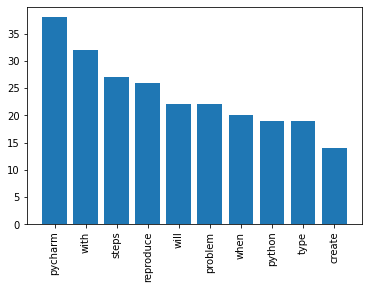

In [42]:
plot_class(0)

In [43]:
words_count = defaultdict(dict)
i = 0
for t in f_tickets_2["head"]:
    for w in t.split():
        w = w.lower().replace("/", " ").replace(".", " ").replace(":", " ")
        w = re.sub('[^a-zA-Z]+', '', w)
        if len(w) <= 3:
            continue
        if w not in words_count[classes[i]]:
            words_count[classes[i]][w] = 1
        else:
            words_count[classes[i]][w] += 1
    i+=1

In [44]:
# Частоты слов в лоб дают просто популярные слова. выкинем лишние.

In [45]:
words_count = defaultdict(dict)
i = 0
for t in f_tickets_2["head"]:
    for w in t.split():
        w = w.lower().replace("/", " ").replace(".", " ").replace(":", " ")
        w = re.sub('[^a-zA-Z]+', '', w)
        if len(w) <= 3:
            continue
        if w in ["pycharm", "with", "step", "when", "python", "problem", "will", "steps", "reproduce"]:
            continue
        if w not in words_count[classes[i]]:
            words_count[classes[i]][w] = 1
        else:
            words_count[classes[i]][w] += 1
    i+=1

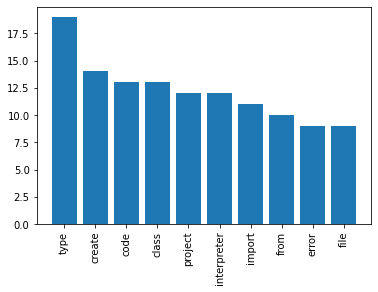

In [46]:
plot_class(0)

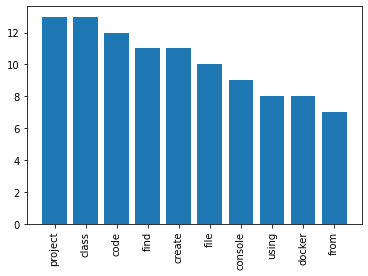

In [47]:
plot_class(1)

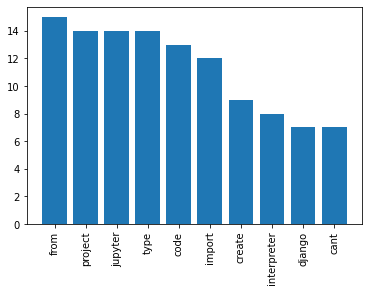

In [48]:
plot_class(2)

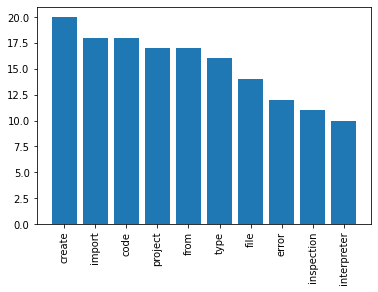

In [49]:
plot_class(3)

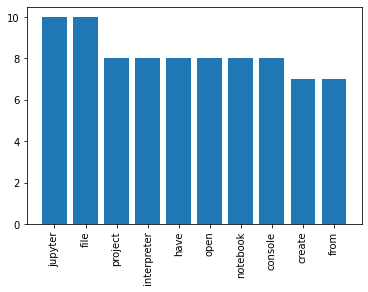

In [50]:
plot_class(4)

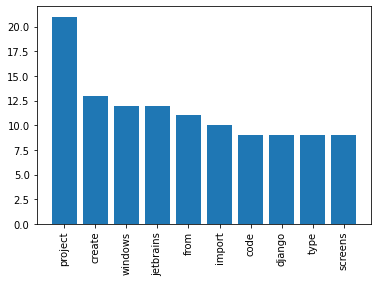

In [51]:
plot_class(5)

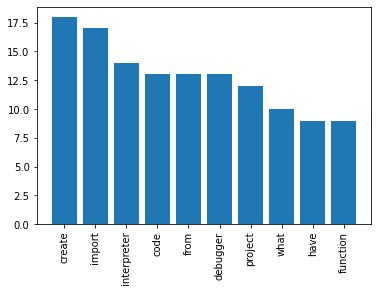

In [52]:
plot_class(6)

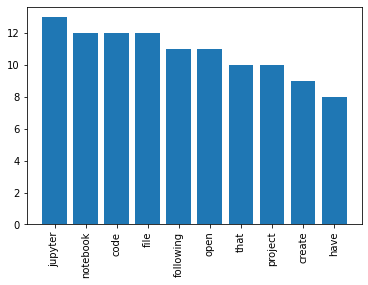

In [53]:
plot_class(7)

Часто встречаются проблемы с юпитером (класс 7 / 4), есть проблемы при работае в ОС windows (класс 5), есть проблемы с инспекциями кода (класс 3, много слов по коду и импорту)

Также есть трудности с докером и дебаггером (классы 1 и 6)

In [54]:
# Обучим аналогично для 2020.3

In [55]:
counter = CountVectorizer(stop_words='english', ngram_range=(2, 3), max_df=0.3)
X_2020_3 = counter.fit_transform(f_tickets_3["head"].values.astype('U'))
counter.get_feature_names_out()

array(['00_add jp', '01 10', '01 10 55', ..., 'zipfile py add',
       'zoom editor', 'zoom editor doesn'], dtype=object)

In [56]:
lda = LDA(n_components=8, random_state=7)
lda.fit(X_2020_3)
tickets = lda.transform(X_2020_3)

In [57]:
for value, code, name, v in zip(tickets.max(axis=0),  f_tickets_3.iloc[tickets.argmax(axis=0)]["idReadable"], f_tickets_3.iloc[tickets.argmax(axis=0)]['summary'], f_tickets_3.iloc[tickets.argmax(axis=0)]['Affected versions']):
    print(value, code, v, name)

0.9801132623074421 PY-45776 ['2020.3'] Analyzing never completes: NPE at com.intellij.psi.util.QualifiedName.matchesPrefix(QualifiedName.java:108)
0.984369696788218 PY-47863 ['2020.3'] Allow variables declaration before non-native namespace package declaration line in dunder init
0.9824974010161436 PY-47478 ['2020.3'] Launching skeleton generator task can not succeed and times out with docker-compose remote Python interpreter using Docker 20.10.4
0.9863278061608026 PY-46887 ['2020.3'] hello harry sir my py charm is not working means coursor is stuck at on one point  it appear very bold I have uninstall and install it 2-3 times but it's not working  please help
0.9809728644174681 PY-47481 ['2020.3'] False-positive "Signature of method ... does not match signature of base method" when keyword-only argument without default value is used.
0.9801122246597967 PY-46410 ['2020.3'] Can't create SSH interpreter: "File /.pycharm_helpers_5: Permission denied" if user doesn't have home folder
0.980

In [58]:
from collections import defaultdict
classes = tickets.argmax(axis=1)
classes_count_3 = defaultdict(int)
for cls in classes:
    classes_count_3[cls] += 1
classes_count_3

defaultdict(int, {0: 54, 1: 84, 2: 67, 3: 62, 4: 54, 5: 75, 6: 58, 7: 68})

In [59]:
words_count = defaultdict(dict)
i = 0
for t in f_tickets_3["head"].values.astype('U'):
    for w in t.split():
        w = w.lower().replace("/", " ").replace(".", " ").replace(":", " ")
        w = re.sub('[^a-zA-Z]+', '', w)
        if len(w) <= 4:
            continue
        if w in ["pycharm", "with", "step", "when", "python", "problem", "will", "steps", "reproduce", "project", "import"]:
            continue
        if w not in words_count[classes[i]]:
            words_count[classes[i]][w] = 1
        else:
            words_count[classes[i]][w] += 1
    i+=1

In [60]:

for i in range(8):
    print(f'class {i+1}')
    dct = words_count[i]
    l = 0
    for kv in sorted(dct.items(), key=lambda item: -item[1]):
        if l == 10:
            break
        l+=1
        print(kv)
    print()

class 1
('create', 11)
('class', 10)
('console', 7)
('install', 6)
('django', 6)
('interpreter', 5)
('package', 5)
('flask', 5)
('imagepng', 5)
('cannot', 4)

class 2
('create', 14)
('docker', 8)
('wrong', 7)
('class', 7)
('warning', 7)
('false', 6)
('cannot', 6)
('interpreter', 6)
('package', 6)
('after', 6)

class 3
('create', 14)
('interpreter', 10)
('django', 9)
('after', 8)
('doesnt', 6)
('using', 6)
('configuration', 5)
('debugger', 5)
('breakpoint', 5)
('allow', 5)

class 4
('create', 10)
('doesnt', 9)
('django', 8)
('package', 7)
('class', 6)
('install', 5)
('console', 5)
('jetbrains', 5)
('request', 5)
('working', 5)

class 5
('create', 8)
('error', 8)
('module', 7)
('class', 6)
('following', 5)
('after', 5)
('notebook', 5)
('doesnt', 5)
('stubs', 5)
('remote', 4)

class 6
('create', 18)
('cannot', 8)
('windows', 7)
('django', 7)
('console', 7)
('using', 7)
('interpreter', 6)
('inspection', 6)
('output', 6)
('after', 5)

class 7
('create', 9)
('interpreter', 6)
('module', 6)
(

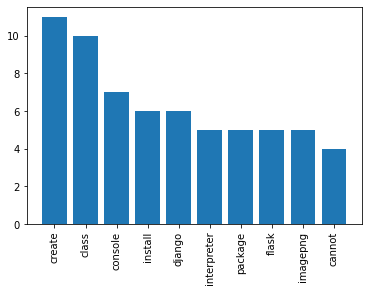

In [61]:
plot_class(0)

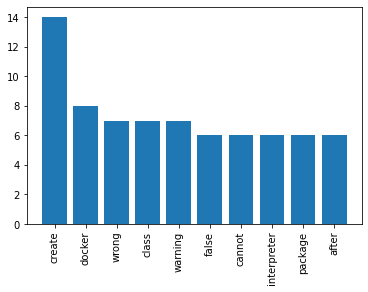

In [62]:
plot_class(1)

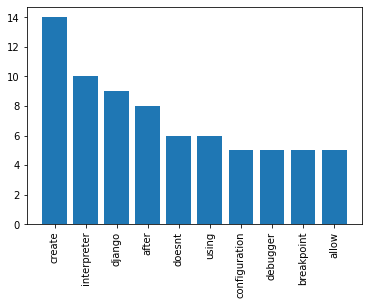

In [63]:
plot_class(2)

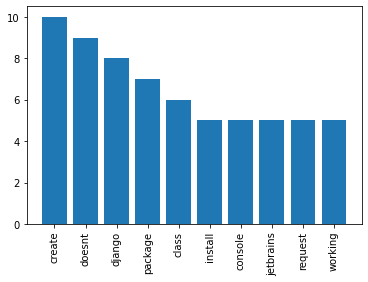

In [64]:
plot_class(3)

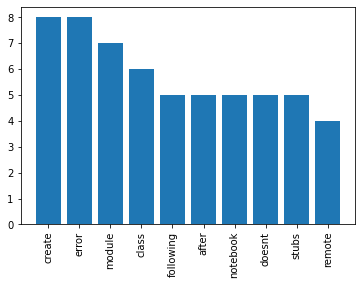

In [65]:
plot_class(4)

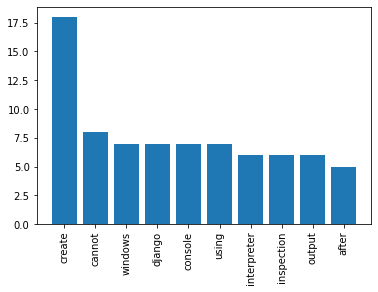

In [66]:
plot_class(5)

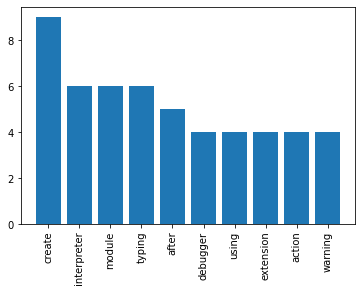

In [67]:
plot_class(6)

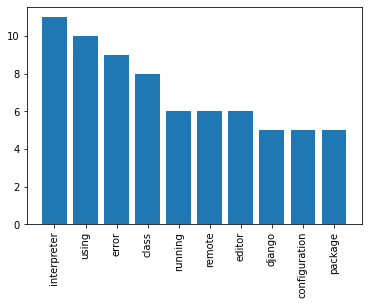

In [68]:
plot_class(7)

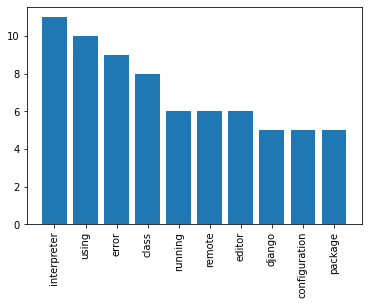

In [69]:
plot_class(7)

Ситуация в целом похожая, Кажется что стало больше проблем с докером, он поднимается вверх по частоте, появились проблемы с дебаггером, его тоже много. В классе 5 появился cython, видимо, перестало что-то собираться в каких-то случаях.


Взамен этого пофиксались проблемы с юпитером и проблемы на windows

Посмотрим еще на распределение по топикам для 2 релизов, посмотрим, что в целом оно похожее.

In [70]:
X_2020_3.shape

(522, 13018)

In [71]:
X_2020_2.shape

(625, 15661)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


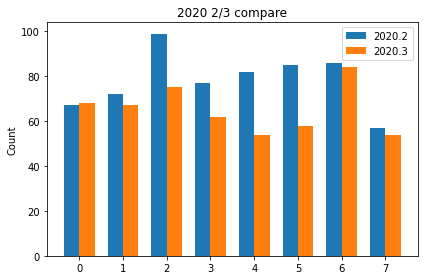

In [72]:
keys1 = []
vals1 = []
dct = words_count[i]
for kv in classes_count_2.items():
    keys1.append(kv[0])
    vals1.append(kv[1])
keys2 = []
vals2 = []
dct = words_count[i]
for kv in classes_count_3.items():
    keys2.append(kv[0])
    vals2.append(kv[1])

import matplotlib.pyplot as plt
import numpy as np


labels = ['0', '1', '2', '3', '4', '5', '6', '7']
men_means = vals1
women_means = list(map(lambda x: x, vals2))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='2020.2')
rects2 = ax.bar(x + width/2, women_means, width, label='2020.3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('2020 2/3 compare')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

Физически стало меньше тикетов. Видно, что поработали по 4 направлениям, 2-5 классы. Это частично перекрывается с исчезнувшими проблемами, так как напрмиер windows попадала в эти классы.

Оценка подводных камней:

1) Классифицировали на фиксированное число топиков. Никак не оценивалось, на какое число классов надо проводить классификацию. Из-за этого топики могли смешиваться между собой, что желает анализ недостаточно широким

2) Некоторые популярные проблемы могут быть зарепорчены одним тикетом с кучей лайков. Без заведения дубликатов. Пользователь мог нагуглить багу и поставить лайк тикету. Из-за этого такие важные попроблемы могли в анализ не попасть.

3) Никак не проверялось, насколько вообще классы для версии 2020.2 и 2020.3 коррелируют, выводы только качественные.

4) Выводы по тому, какой проблеме соответствует тот или иной топик, не проверялись - надо было бы проанализировать и проверить полученные гипотезы

In [73]:
# 